In [6]:
# Import dependencies

import numpy as np
import pandas as pd

import os

%load_ext autoreload
%autoreload 2

SEED = 42
np.random.seed(SEED)

SLIDING_WINDOW_SIZE = 10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Load data
import helpers

GROUPING_FEATURE = "datetime_key"
LABEL = "activity"
FEATURES = ["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"]

data_path = os.path.join('dataset', 'dataset_preprocessed.csv')
dataframe = pd.read_csv(data_path)
dfs = [v for _, v in dataframe.groupby(GROUPING_FEATURE)]

tuples = []

for df in dfs:
    tuples.append((df, df[LABEL].iloc[0]))
  
x, y = helpers.generate_data(tuples, features=["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"], window_size=SLIDING_WINDOW_SIZE)

print("Shape of feature vector is " + str(x.shape))
print("Shape of output vector is " + str(y.shape))

Shape of feature vector is (17680, 10, 6)
Shape of output vector is (17680,)


In [8]:
# Split data
from sklearn.model_selection import train_test_split

raw_x_train, raw_x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

print("Shape of raw_x_train is " + str(raw_x_train.shape))
print("Shape of y_train is " + str(y_train.shape))
print("Shape of raw_x_test is " + str(raw_x_test.shape))
print("Shape of y_test is " + str(y_test.shape))

Shape of raw_x_train is (14144, 10, 6)
Shape of y_train is (14144,)
Shape of raw_x_test is (3536, 10, 6)
Shape of y_test is (3536,)


In [9]:
# Extract features

x_train = helpers.convert_time_series_to_features(raw_x_train)
print("Shape of training feature vector is " + str(x_train.shape))

x_test = helpers.convert_time_series_to_features(raw_x_test)
print("Shape of testing feature vector is " + str(x_test.shape))

Shape of training feature vector is (14144, 80)
Shape of testing feature vector is (3536, 80)


C:\Users\tohmi\AppData\Local\Temp\ipykernel_16396\946110836.py:24: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\b\abs_e1nmgx0bk6\croot\pytorch-select_1725478824526\work\aten\src\ATen\native\Copy.cpp:300.)
  y_pred = model(torch.tensor(x_train).float())


Epoch 0 Loss 0.7928341627120972
Epoch 100 Loss 0.4116114675998688
Epoch 200 Loss 0.4027828276157379
Epoch 300 Loss 0.3976745903491974
Epoch 400 Loss 0.394036203622818
Epoch 500 Loss 0.39100733399391174
Epoch 600 Loss 0.3879692852497101
Epoch 700 Loss 0.3856430649757385
Epoch 800 Loss 0.383989542722702
Epoch 900 Loss 0.3820975124835968
Epoch 1000 Loss 0.3803621828556061
Epoch 1100 Loss 0.37915629148483276
Epoch 1200 Loss 0.37821364402770996
Epoch 1300 Loss 0.3772648274898529
Epoch 1400 Loss 0.37657076120376587
Accuracy on training set is 0.9396210407239819


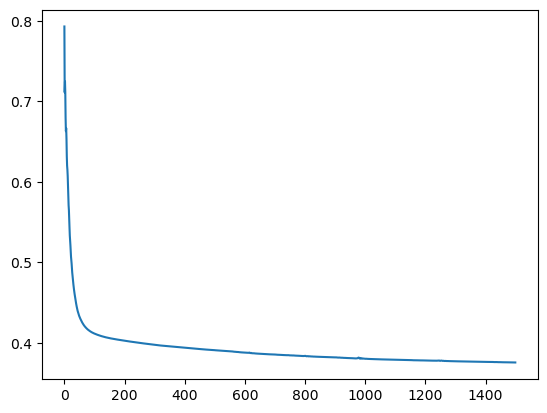

In [10]:
import torch
import torch.nn as nn

LEARNING_RATE = 0.001
EPOCHS = 1500

# Define the model
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(torch.tensor(x_train).float())
    loss = loss_fn(y_pred, torch.tensor(y_train).long())
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss {loss.item()}")
        
model.eval()
y_pred = model(torch.tensor(x_train).float())
y_pred = torch.argmax(y_pred, dim=1)

# Evaluate training accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy on training set is {accuracy}")

# Plot the loss
import matplotlib.pyplot as plt

plt.plot(losses)

In [11]:
# Evaluate the model

model.eval()
y_pred = model(torch.tensor(x_test).float())
y_pred = torch.argmax(y_pred, dim=1)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on testing set is {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

# confusion_matrix(y_test, y_pred)
# display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=range(6))

# display.plot()


Accuracy on testing set is 0.9052601809954751
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1782
           1       0.91      0.89      0.90      1754

    accuracy                           0.91      3536
   macro avg       0.91      0.91      0.91      3536
weighted avg       0.91      0.91      0.91      3536



In [19]:
# Save the weights

weights_str = ""
biases_str = ""

for param in model.named_parameters():
    isBias = False
    if "0.weight" in param[0]:
        weights_str += ("custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {")
        isBias = False
    if "0.bias" in param[0]:
        biases_str += ("custom_float input_bias[HIDDEN_LAYER_NODES] = {")
        isBias = True
    if "2.weight" in param[0]:
        weights_str += ("custom_float output_weight[HIDDEN_LAYER_NODES * OUTPUT_NODES] = {")
        isBias = False
    if "2.bias" in param[0]:
        biases_str += ("custom_float output_bias[OUTPUT_NODES] = {")
        isBias = True
        
    weight = param[1].detach().numpy().flatten().tolist()
    for w in weight:
        if isBias:
            biases_str += str(w) + ","
        else:
            weights_str += str(w) + ","
            
    if isBias:
        biases_str += "};\n\n"
    else:
        weights_str += "};\n\n"
        
print(weights_str)
print(biases_str)

custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {0.07827688008546829,0.007289620116353035,0.2075463831424713,-0.06875396519899368,-0.09954354166984558,-0.0787668228149414,-0.0061787692829966545,-0.010727500542998314,0.028192972764372826,-0.09297923743724823,0.016164487227797508,-0.137539342045784,-0.005220318213105202,0.10289730876684189,-0.06988518685102463,0.1053234413266182,0.1626971811056137,-0.13355469703674316,0.2032368928194046,-0.15095429122447968,-0.01257809903472662,5.413055987446569e-05,-0.14085674285888672,0.07444201409816742,-0.07043486088514328,-0.039210591465234756,0.24644456803798676,-0.04414234310388565,-0.1318807154893875,-0.07739132642745972,-0.07451862841844559,0.07911539077758789,0.09802845865488052,-0.12413406372070312,0.21116207540035248,-0.09431832283735275,-0.13386167585849762,0.11501038819551468,-0.054182954132556915,0.1187354326248169,0.04381772130727768,0.08915864676237106,0.05655846372246742,-0.07922766357660294,-0.1125641018152237,-0.12080131